In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
!pip3 install tensorflow pydot pydotplus >> /dev/null

In [5]:
import pandas as pd
import sys
import tensorflow as tf



sys.path.insert(1, '../preprocessing/')
sys.path.insert(1, '../graphs/')
from dataset_lib import load_dataset, split_dataset, divide_X_Y, shift, remove_first_day
from graphs_lib import plot_predictions



In [6]:
df = load_dataset()

Putting together /mnt/f/proyectos/bikes/src/models/../../data/files/../parts/chicago-divvy-trips-part-1
Putting together /mnt/f/proyectos/bikes/src/models/../../data/files/../parts/chicago-divvy-trips-part-2
Putting together /mnt/f/proyectos/bikes/src/models/../../data/files/../parts/chicago-divvy-trips-part-3


In [7]:
train_df, val_df, test_df = split_dataset(df)
train_df_hat = shift(train_df)
val_df_hat = shift(val_df)
test_df_hat = shift(test_df)

Training from 2017-01-01 00:00:00 to 2017-12-31 23:00:00
Validating from 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Testing from 2019-01-01 00:00:00 to 2019-12-31 23:00:00


## Baseline forecast

This prediction will be based on the previous day only

In [8]:
train_X, train_Y = divide_X_Y(remove_first_day(train_df))
val_X, val_Y = divide_X_Y(remove_first_day(val_df))
test_X, test_Y = divide_X_Y(remove_first_day(test_df))

train_X_hat, train_Y_hat = divide_X_Y(train_df_hat)
val_X_hat, val_Y_hat = divide_X_Y(val_df_hat)
test_X_hat, test_Y_hat = divide_X_Y(test_df_hat)

In [9]:
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError, MeanAbsoluteError, Huber
from tensorflow.keras.metrics import RootMeanSquaredError

msle = MeanSquaredLogarithmicError()
mse = MeanSquaredError()
mae = MeanAbsoluteError()
huber = Huber()
rmse = RootMeanSquaredError()

def rmsle(y_true, y_pred):
    return tf.keras.backend.sqrt(msle(y_true, y_pred))


In [10]:
errors_fn = [msle, mse, mae, huber, rmse, rmsle]
train = [e(train_Y, train_Y_hat).numpy() for e in errors_fn]
val = [e(val_Y, val_Y_hat).numpy() for e in errors_fn]
test = [e(test_Y, test_Y_hat).numpy() for e in errors_fn]

errors = pd.DataFrame({
    "names": ["msle", "mse", "mae", "huber", "rmse", "rmsle"],
    "train": train,
    "val": val,
    "test": test,
})
errors

,names,train,val,test
0,msle,0.214735,0.206354,0.221913
1,mse,3.316299,2.826107,3.122278
2,mae,0.608971,0.576106,0.615524
3,huber,0.467653,0.436227,0.469799
4,rmse,1.821071,1.752485,1.757335
5,rmsle,0.463395,0.454262,0.471077


In [11]:
print(errors.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &  names &     train &       val &      test \\
\midrule
0 &   msle &  0.214735 &  0.206354 &  0.221913 \\
1 &    mse &  3.316299 &  2.826107 &  3.122278 \\
2 &    mae &  0.608971 &  0.576106 &  0.615524 \\
3 &  huber &  0.467653 &  0.436227 &  0.469799 \\
4 &   rmse &  1.821071 &  1.752485 &  1.757335 \\
5 &  rmsle &  0.463395 &  0.454262 &  0.471077 \\
\bottomrule
\end{tabular}



In [12]:
errors.to_csv(f"../../results/baseline.csv")

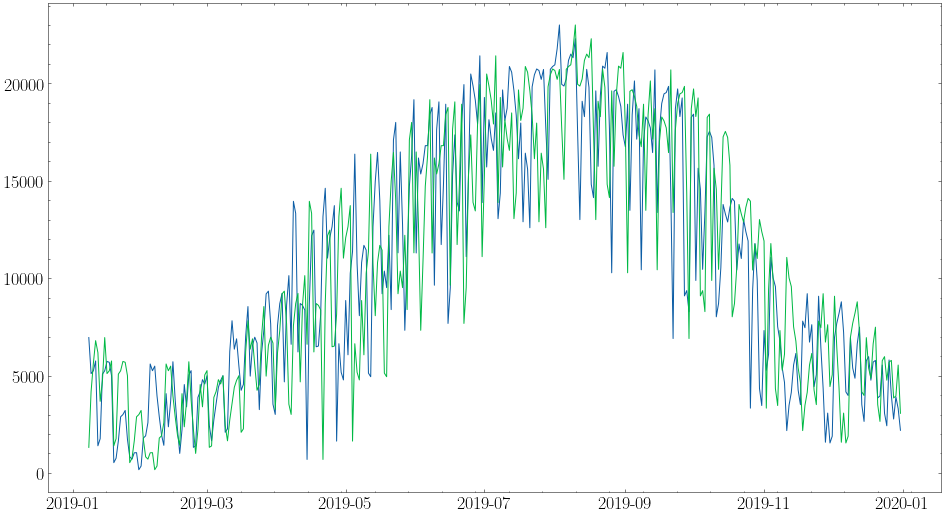

In [15]:
plot_predictions(test_Y, test_Y_hat, "baseline-predictions.png")